 Reinforcement Learning Problem Formulation for Movie Recommendation using Multi-Armed Bandits

 Environment: A movie streaming platform
 Agent: A recommendation system
 Actions: Recommending a movie from a set of available movies
 Rewards: User engagement metrics such as clicks, likes, and ratings

 The problem can be modeled as a Multi-Armed Bandit problem where each movie represents an arm.

 The agent needs to select an arm (movie) at each timestep to recommend to the user.

 The agent's goal is to maximize the cumulative reward over a period of time by recommending movies that are most likely to engage the user.

 The reward received by the agent after each recommendation is a stochastic function of the selected movie and the user's response to it.

 The agent uses the received reward to update its belief about the expected reward of each movie.

 The agent employs an exploration-exploitation trade-off strategy to balance between recommending movies that have high expected rewards based on past data (exploitation) and exploring new movies to gather more data about their expected rewards (exploration).
 
 The agent can use different algorithms such as epsilon-greedy, UCB (Upper Confidence Bound), or Thompson Sampling to solve the Multi-Armed Bandit problem and recommend movies to the user.


In [1]:

import tensorflow as tf
!pip install tf_agents
import tf_agents
from tf_agents.bandits.environments import movielens_py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.bandits.environments import environment_utilities
from tf_agents.bandits.metrics import tf_metrics as tf_bandit_metrics
from tf_agents.bandits.agents import lin_ucb_agent
from tf_agents.bandits.agents import linear_thompson_sampling_agent as lin_ts_agent
from tf_agents.networks import q_network
from tf_agents.bandits.agents import neural_epsilon_greedy_agent as eps_greedy_agent
from tf_agents.bandits.agents.examples.v2 import trainer
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.drivers import driver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.policies import random_tf_policy
import functools
import os
import numpy as np
from matplotlib import pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 54.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697659 sha256=727af1440a967bc08f0ab49fd5e41db199df6367bf62370bca177c576419a9a1
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2


In [2]:

BATCH_SIZE = 8
TRAINING_LOOPS = 500
STEPS_PER_LOOP = 2
RANK_K = 20
NUM_ACTIONS = 20

data_path = 'u.data'

In [3]:

env = movielens_py_environment.MovieLensPyEnvironment(
        data_path,
        RANK_K,
        BATCH_SIZE,
        num_movies=NUM_ACTIONS,
        csv_delimiter='\t')
environment = tf_py_environment.TFPyEnvironment(env)

In [4]:

optimal_reward_fn = functools.partial(
      environment_utilities.compute_optimal_reward_with_movielens_environment,
      environment=environment)


optimal_action_fn = functools.partial(
      environment_utilities.compute_optimal_action_with_movielens_environment,
      environment=environment)

In [5]:

AGENT_ALPHA = 10.0
linucb = lin_ucb_agent.LinearUCBAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        tikhonov_weight=0.001,
        alpha=AGENT_ALPHA,
        dtype=tf.float32,
        accepts_per_arm_features=False)

In [6]:

lints = lin_ts_agent.LinearThompsonSamplingAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        dtype=tf.float32,
        accepts_per_arm_features=False)

In [7]:

EPSILON = 0.05
LAYERS = (50, 50, 50)
LR = 0.005

network = q_network.QNetwork(
          input_tensor_spec=environment.time_step_spec().observation,
          action_spec=environment.action_spec(),
          fc_layer_params=LAYERS)

neureps = eps_greedy_agent.NeuralEpsilonGreedyAgent(
        time_step_spec=environment.time_step_spec(),
        action_spec=environment.action_spec(),
        reward_network=network,
        optimizer=tf.compat.v1.train.AdamOptimizer(learning_rate=LR),
        epsilon=EPSILON,
        emit_policy_info='predicted_rewards_mean',
        info_fields_to_inherit_from_greedy=['predicted_rewards_mean'])

In [8]:
regret_metric = tf_bandit_metrics.RegretMetric(optimal_reward_fn)
suboptimal_arms_metric = tf_bandit_metrics.SuboptimalArmsMetric(optimal_action_fn)

In [9]:
def train(agent):

  if agent == 'LinUCB':
    agent = linucb
  elif agent == 'LinTS':
    agent = lints
  elif agent == 'NeurEps':
    agent = neureps


  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.policy.trajectory_spec,
    batch_size=BATCH_SIZE,
    max_length=STEPS_PER_LOOP)

  observers = [replay_buffer.add_batch, regret_metric]

  driver = dynamic_step_driver.DynamicStepDriver(
      env=environment,
      policy=agent.collect_policy,
      num_steps=STEPS_PER_LOOP * BATCH_SIZE,
      observers=observers)

  regret_values = []

  for _ in range(TRAINING_LOOPS):
    driver.run()
    loss_info = agent.train(replay_buffer.gather_all())
    replay_buffer.clear()
    regret_values.append(regret_metric.result())

  return regret_values, agent

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Text(0, 0.5, 'Average Regret')

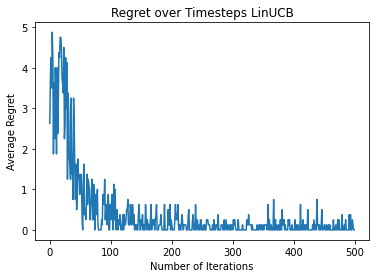

In [10]:
regret_values_linucb, linucb_agent = train('LinUCB')
plt.plot(regret_values_linucb)
plt.title('Regret over Timesteps LinUCB')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [11]:
sum(regret_values_linucb)

<tf.Tensor: shape=(), dtype=float32, numpy=220.375>

Text(0, 0.5, 'Average Regret')

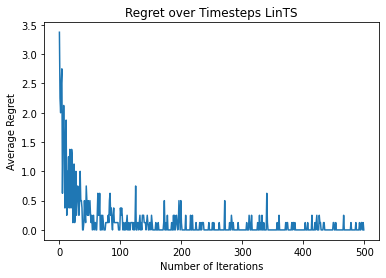

In [12]:
regret_values_lints, lints_agent = train('LinTS')
plt.plot(regret_values_lints)
plt.title('Regret over Timesteps LinTS')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [13]:
sum(regret_values_lints)

<tf.Tensor: shape=(), dtype=float32, numpy=71.375>

Text(0, 0.5, 'Average Regret')

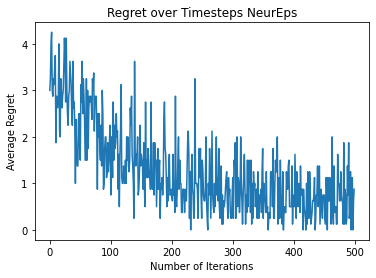

In [14]:
regret_values_neureps, neureps_agent = train('NeurEps')
plt.plot(regret_values_neureps)
plt.title('Regret over Timesteps NeurEps')
plt.xlabel('Number of Iterations')
plt.ylabel('Average Regret')

In [15]:
sum(regret_values_neureps)

<tf.Tensor: shape=(), dtype=float32, numpy=641.5>

In [16]:
def recommend_movies(agent, observation):
    time_step = tf_agents.trajectories.time_step.TimeStep(
        step_type=tf.constant([[2]], dtype=tf.int32),
        reward=tf.constant([[0.0]], dtype=tf.float32),
        discount=tf.constant([[1.0]], dtype=tf.float32),
        observation=observation)
    
    action_step = agent.policy.action(time_step)
    return action_step.action.numpy()[0]

In [17]:
observation = np.array([1, 25, 35, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1])
observation = np.expand_dims(observation, axis=0)
recommend_movies(lints_agent, observation=observation)

13